In [1]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [2]:
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint

messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
messages.append(HumanMessage(content=f"I want to learn coding",name="Krish"))
messages.append(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn python programming language",name="Krish"))

for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help
================================ Human Message =================================
Name: Krish

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn
================================ Human Message =================================
Name: Krish

I want to learn python programming language


In [3]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="gemma2-9b-it")
result=llm.invoke(messages)

In [4]:
result

AIMessage(content="That's great! Python is a fantastic choice for beginners. It's known for its readability and versatility.  \n\nTo help you get started, tell me:\n\n* **What's your current experience with coding?** (None, some, etc.)\n* **What are your goals for learning Python?** (Web development, data science, scripting, etc.)\n* **How do you prefer to learn?** (Online courses, books, interactive tutorials, etc.)\n\n\nOnce I know a bit more about you, I can give you some personalized recommendations for learning resources and next steps. \n\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 128, 'prompt_tokens': 55, 'total_tokens': 183, 'completion_time': 0.232727273, 'prompt_time': 0.002191148, 'queue_time': 0.252387631, 'total_time': 0.234918421}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--98108246-f191-4845-928e-23c4ed79895f-0', usage_metadat

In [5]:
def add(a:int,b:int)-> int:
    """ Add a and b
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int
    """
    return a+b

In [6]:
### Binding tool with llm

llm_with_tools=llm.bind_tools([add])

tool_call=llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 2",name="Krish")])

In [7]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'cnp1ncz2s',
  'type': 'tool_call'}]

In [8]:
# FIXED: Consistent State class definition using "messages" (plural)
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [9]:
initial_messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Krish"))
initial_messages

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Krish')]

In [10]:
ai_message=AIMessage(content=f"Which programming language you want to learn",name="LLMModel")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [11]:
### Reducers add_messages is to append instead of override
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='baaff942-c271-4d1b-9132-e424fee457e8'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Krish', id='bc9aaf78-9cd0-42f9-b88c-f24fe40f441c'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='d0aeb86a-4d7c-4b2f-93f1-f6f3296e9c75')]

In [12]:
# FIXED: Chatbot node functionality with correct state key
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

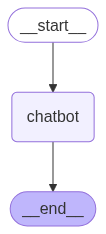

In [13]:
# Simple graph without tools first
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
builder=StateGraph(State)

builder.add_node("chatbot", chatbot)

builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

simple_graph = builder.compile()

display(Image(simple_graph.get_graph().draw_mermaid_png()))

In [14]:
# FIXED: Test with proper message format
from langchain_core.messages import HumanMessage

messages = simple_graph.invoke({"messages": [HumanMessage(content="What is 2 plus 2")]})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (h285ja8yg)
 Call ID: h285ja8yg
  Args:
    a: 2
    b: 2


In [15]:
tools=[add]

In [16]:
# FIXED: Complete graph with tools that actually execute and return results
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

## Add nodes
builder.add_node("chatbot", chatbot)
builder.add_node("tools", ToolNode(tools))

## FIXED: Add proper edges for complete tool execution flow
builder.add_edge(START, "chatbot")
builder.add_conditional_edges(
    "chatbot",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
# FIXED: Tools return to chatbot for final response instead of END
builder.add_edge("tools", "chatbot")

graph = builder.compile()

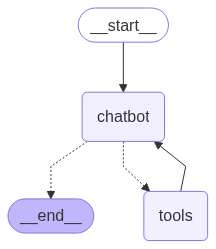

In [17]:
# Display the fixed graph structure
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
# FIXED: Test math question with proper execution
print("Testing Math Question:")
print("=" * 30)

messages = graph.invoke({"messages": [HumanMessage(content="What is 2 plus 2?")]})

print("Final Result:")
for message in messages["messages"]:
    message.pretty_print()

Testing Math Question:
Final Result:
================================ Human Message =================================

What is 2 plus 2?
================================== Ai Message ==================================
Tool Calls:
  add (h4qkjkrhz)
 Call ID: h4qkjkrhz
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4
================================== Ai Message ==================================

4


In [19]:
# FIXED: Test non-math question
print("Testing Non-Math Question:")
print("=" * 30)

messages = graph.invoke({"messages": [HumanMessage(content="What is machine learning?")]})

print("Final Result:")
for message in messages["messages"]:
    message.pretty_print()

Testing Non-Math Question:
Final Result:
================================ Human Message =================================

What is machine learning?
================================== Ai Message ==================================
Tool Calls:
  add (qa2rzgmqh)
 Call ID: qa2rzgmqh
  Args:
    a: 1
    b: 2
================================= Tool Message =================================
Name: add

3
================================== Ai Message ==================================

Machine learning is a type of artificial intelligence (AI) that allows software applications to become more accurate at predicting outcomes without being explicitly programmed to do so. 

Machine learning algorithms use historical data as input to learn patterns and relationships, and then use those patterns to make predictions about new data.
